Pt  : (-3,939,555.39, -4,001,939.75, 3,001,454.81), l = 6,367,444.50 
Sat : (-16,971,520.74, -24,205,073.75, -17,730,415.46), l = 34,471,520.77 
Angle between P & S  : 59.770
Angle between P & PS : 110.251
Satellite  in view


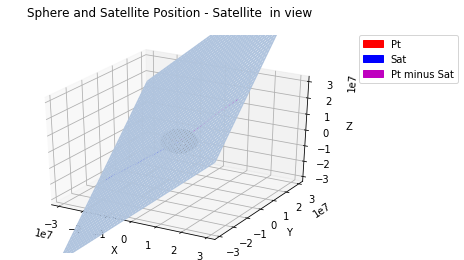

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
%matplotlib notebook
from time import time
from random import seed
from random import random
import numpy as np
import math as m

seed(time())

class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)


def dot(x,y):
    '''
    Returns the dot product of two equal sizes lists/vectors.

    Parameters
    ----------
    x : list
        n-by-1 vector of real numbers
    y : list
        n-by-1 vector of real numbers
    '''

    assert len(x) == len(y)
    return sum([x*y for x,y in zip(x,y)])


def scalar(k, x):
    '''
    Returns a k-scaled vector of x.

    Parameters
    ----------
    k : real number
        scalar
    x : list
        n-by-1 vector of real numbers
    '''
    return [k*val for val in x]


def norm(x,p=2):
    '''
    Returns the vector norm for x. Default is 2-norm.
    
    Parameters
    ----------
    x : list
        n-by-1 vector of real numbers
    p : integer
        Norm dimension, default is 2 which is distance from origin
    '''
    return (sum([m.fabs(val)**p for val in x]))**(1/p)


def diff(x,y):
    '''
    Returns a vector that is the difference between x and y.
    
    Parameters
    ----------
    x : list
        n-by-1 vector of real numbers
    y : list
        n-by-1 vector of real numbers
    '''
    assert len(x) == len(y)
    return [x - y for x,y in zip(x,y)]


def find_angle(x,y, in_radians=True):
    '''
    Returns the angle between two vectors x & y.

    Parameters
    ----------
    x : list
        n-by-1 vector of real numbers
    y : list
        n-by-1 vector of real numbers
    in_radians : bool
        True for angle in radians, False for angle in decimal degrees
    '''

    alpha = m.acos(dot(x,y) / (norm(x) * norm(y)))
    if not in_radians:
        alpha = m.degrees(alpha)
    return alpha


def get_sat_pos(bounds, size=3):
    '''
    Return a random vector for the position of a satellite
    
    Parameters
    ----------
    bounds : 2-tuple
        Domain for each value in the vector
    size : integer
        Number of elements to describe the satellite position
    '''
    lbound, ubound = bounds
    vec = [lbound + (random()*(ubound - lbound)) for i in range(size)]

    vec_norm = norm(vec)
    dist = 4.172387289751799                # Sat dist / Radius dist ratio from project paper i.e. the altitude 
                                            # of any satellite is 4.17 times the distance from the origin than 
                                            # the radius of earth
                            
    if vec_norm <= dist:                    # If the vector norm (distance) is proporitionally small, scale it up
        vec = scalar(dist/vec_norm, vec)
    return vec


def get_point_on_sphere(radius):

    sign = 1 if random() < 0.5 else -1
    a = sign*0.8*radius*random()                # multiply by 0.8 to avoid precision limits that cause div / 0 errors

    sign = 1 if random() < 0.5 else -1
    b = sign*0.8*m.sqrt(radius**2 - (a)**2)     # multiply by 0.8 to avoid precision limits that cause div / 0 errors

    sign = 1 if random() < 0.5 else -1
    c = sign * m.sqrt(radius**2 - a**2 - b**2)
    
    assert m.fabs(a**2 + b**2 + c**2 - radius**2) <= 10e-3
    
    return (a, b, c)


def tangent_plane(point,r):
    '''
    Returns a vectorized lambda function for a surface plane tangent to a point on a sphere with origin (0,0,0).

    Parameters
    ----------
    '''
    assert len(point) == 3
    return np.vectorize(lambda x, y: (r**2 - point[0]*x - point[1]*y) / point[2])


def sat_in_view(point, sat, ps=None):
    '''
    Returns a text decision for whether sat is in view from point. A sat is in view from point if it is above the horizion of point.

    Let alpha be the angle between the vectors point and satellite. Let beta be the angle between the vectors ps and point where ps is the difference between point and satellite. 

    A satellite is in view of the vector point if alpha is less than 90 degrees and beta is greater than 90 degrees.

    Parameters
    ----------
    point : n-tuple/list
        n-by-1 dimensional vector that is the viewpoint
    sat : n-tuple/list
        n-by-1 dimensional vector that is being examined
    ps : n-tuple/list
        n-by-1 dimensional vector that is the difference between point and sat
    '''

    if ps is None: ps = diff(point, sat)

    alpha = find_angle(point,satellite, False)
    print(f"Angle between P & S  : {alpha:.3f}")
    beta = find_angle(point, ps, False)
    print(f"Angle between P & PS : {beta:.3f}")

    if alpha < 90.0 and beta > 90.0:
        result = ''
    else:
        result = 'not'

    decision = f"Satellite {result} in view"
    print(decision)
    return decision


def plotter(radius, sat_vec, point_vec, dif_vec, tangent_func, domain, title_text, xlim, ylim, zlim):
    '''
    Custom plotting function for this mess of an analysis.

    Parameters
    ----------
    sat_vec : 2-tuple/list
        2-by-1 vector describing the vectors position
    point_vec : 2-tuple/list
        2-by-1 vector describing the points position
    dif_vec : 2-tuple/list
        2-by-1 vector that is the difference between point_vec and sat_vec
    tangent_fun : vectorized function
        Function that describes the line tangent to point_vec
    domain : 2-tuple/list
        Lower and upper bounds for graphing
    title_text : str
        Text for whether the satellite is in view that is included in the figures title
    xlim : 2-tuple/list
        x-axis value limits
    ylim : 2-tuple/list
        y-axis value limits
    zlim : 2-tuple/list
        y-axis value limits
    '''

    fig = plt.figure()
    fig.suptitle("Sphere and Satellite Position - " + title_text)

    # Generate Tangent Plane
    xyvals = np.linspace(domain[0], domain[1], 1000)
    ax = fig.gca(projection = '3d')
    X,Y = np.meshgrid(xyvals, xyvals)
    Z = tangent_func(X,Y)
    ax.plot_wireframe(X,Y,Z, color = 'lightsteelblue')

    # draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = radius*np.cos(u)*np.sin(v)
    y = radius*np.sin(u)*np.sin(v)
    z = radius*np.cos(v)
    ax.plot_wireframe(x, y, z, color="grey")

    # draw point on sphere vector
    point = Arrow3D([0, point_vec[0]], [0, point_vec[1]], [0, point_vec[2]],
            lw=1, arrowstyle="-|>", color="r")
    ax.add_artist(point)

    # draw satellite vector
    sat = Arrow3D([0, sat_vec[0]], [0, sat_vec[1]], [0, sat_vec[2]],
            lw=1, arrowstyle="-|>", color="b")
    ax.add_artist(sat) 

    # draw diff vec
    dif = Arrow3D([0, dif_vec[0]], [0, dif_vec[1]], [0, dif_vec[2]],
            lw=1, arrowstyle="-|>", color="m")
    ax.add_artist(dif)

    # Handle legend entries
    plt.legend(handles=[point, sat, dif], labels=["Pt", "Sat", "Pt minus Sat"],
               bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


radius = 6_367_444.50
domain = (-5*radius,5*radius)               # Domain for graphining & satellite
p = get_point_on_sphere(radius=radius)      # Generate random vector point on sphere
satellite = get_sat_pos(bounds=domain)      # Generate random vector point for satellite

print(f"Pt  : ({p[0]:,.2f}, {p[1]:,.2f}, {p[2]:,.2f}), l = {norm(p):,.2f} ")
print(f"Sat : ({satellite[0]:,.2f}, {satellite[1]:,.2f}, {satellite[2]:,.2f}), l = {norm(satellite):,.2f} ")

# Decision whether the satellite is in view
a = diff(p, satellite)
title_text = sat_in_view(p, satellite, a)

# Lamdbda function to generate line tangent to point on circle
horizon = tangent_plane(p, radius)

# Graph everything
plotter(radius, satellite, p, a, horizon, domain, title_text, domain, domain, domain)